### Import Libraries and Read Data

In [2]:
## Import Libraries
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from io import StringIO

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 8]
pd.plotting.register_matplotlib_converters()
plt.style.use('seaborn-dark')

In [4]:
download_link = 'https://www.arcgis.com/sharing/rest/content/items/f10774f1c63e40168479a1feb6c7ca74/data'
# see https://www.arcgis.com/home/item.html?id=dd4580c810204019a7b8eb3e0b329dd6
# new source https://www.arcgis.com/home/item.html?id=f10774f1c63e40168479a1feb6c7ca74

In [5]:
req = requests.get(download_link)
rki_raw = pd.read_csv(StringIO(req.text))

In [6]:
rki_raw.tail()

,FID,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2
132782,5806838,16,Thüringen,LK Altenburger Land,A60-A79,W,1,0,2020/04/22 00:00:00,16077,"10.05.2020, 00:00 Uhr",0,-9,2020/04/17 00:00:00,0,1,1,Nicht übermittelt
132783,5806839,16,Thüringen,LK Altenburger Land,A80+,M,1,1,2020/03/24 00:00:00,16077,"10.05.2020, 00:00 Uhr",0,0,2020/03/16 00:00:00,-9,0,1,Nicht übermittelt
132784,5806840,16,Thüringen,LK Altenburger Land,A80+,M,1,0,2020/03/27 00:00:00,16077,"10.05.2020, 00:00 Uhr",0,-9,2020/03/23 00:00:00,0,1,1,Nicht übermittelt
132785,5806841,16,Thüringen,LK Altenburger Land,A80+,M,1,0,2020/05/07 00:00:00,16077,"10.05.2020, 00:00 Uhr",0,-9,2020/05/05 00:00:00,-9,0,1,Nicht übermittelt
132786,5806842,16,Thüringen,LK Altenburger Land,A80+,W,1,0,2020/05/06 00:00:00,16077,"10.05.2020, 00:00 Uhr",0,-9,2020/05/04 00:00:00,-9,0,1,Nicht übermittelt


In [7]:
def new_cases_by_date(rki_raw, rki_flag_column='Neuer Fall', rki_count_columns='AnzahlFall'):
    """
    rki_raw: raw DataFrame from Robert Koch Institute
    """
    condition = rki_raw[rki_flag_column].isin((0, 1))
    rki_series = rki_raw[condition].groupby('Meldedatum').sum()[rki_count_columns].copy()
    rki_series.index = pd.to_datetime(rki_series.index)
    rki_series.sort_index(inplace=True)
    return rki_series

In [8]:
rki_cases = new_cases_by_date(rki_raw, rki_flag_column='NeuerFall', rki_count_columns='AnzahlFall')
rki_death = new_cases_by_date(rki_raw, rki_flag_column='NeuerTodesfall', rki_count_columns='AnzahlTodesfall')
rki_recovered = new_cases_by_date(rki_raw, rki_flag_column='NeuGenesen', rki_count_columns='AnzahlGenesen')

In [35]:
rki = pd.concat([rki_cases, rki_death, rki_recovered], axis=1, sort=True)
columns_dict = {'AnzahlFall': 'NewCases', 'AnzahlTodesfall': 'NewDeath', 'AnzahlGenesen': 'NewRecoveredRKI'}
rki.rename(columns_dict, axis=1, inplace=True)
# better use our own estimate as well..
rki['NewRecovered'] = rki.NewRecoveredRKI.shift(14).fillna(0)
s = rki['NewRecoveredRKI'].copy()
s.values[:-14] = 0.
rki['NewRecovered'] + s
rki.fillna(value=0., inplace=True)
rki.tail()

,NewCases,NewDeath,NewRecoveredRKI,NewRecovered
Meldedatum,,,,
2020-05-05,1081,14.0,89,1562.0
2020-05-06,1191,11.0,63,1661.0
2020-05-07,1140,6.0,58,1438.0
2020-05-08,814,1.0,23,1278.0
2020-05-09,349,0.0,4,784.0


In [36]:
rki['Cases'] = rki['NewCases'].cumsum()
rki['Death'] = rki['NewDeath'].cumsum()
rki['Recovered'] = rki['NewRecovered'].cumsum()
rki['ActiveCases'] = rki['Cases'] - rki['Recovered'] - rki['Death']
rki['Growth'] = rki['NewCases'] / rki['ActiveCases']
rki.tail(10)

,NewCases,NewDeath,NewRecoveredRKI,NewRecovered,Cases,Death,Recovered,ActiveCases,Growth
Meldedatum,,,,,,,,,
2020-04-30,1470,34.0,351,2533.0,161980,7312.0,129222.0,25446.0,0.057769
2020-05-01,891,17.0,150,2214.0,162871,7329.0,131436.0,24106.0,0.036962
2020-05-02,632,11.0,80,1500.0,163503,7340.0,132936.0,23227.0,0.027210
2020-05-03,424,6.0,44,885.0,163927,7346.0,133821.0,22760.0,0.018629
2020-05-04,716,17.0,84,1100.0,164643,7363.0,134921.0,22359.0,0.032023
2020-05-05,1081,14.0,89,1562.0,165724,7377.0,136483.0,21864.0,0.049442
2020-05-06,1191,11.0,63,1661.0,166915,7388.0,138144.0,21383.0,0.055698
2020-05-07,1140,6.0,58,1438.0,168055,7394.0,139582.0,21079.0,0.054082
2020-05-08,814,1.0,23,1278.0,168869,7395.0,140860.0,20614.0,0.039488


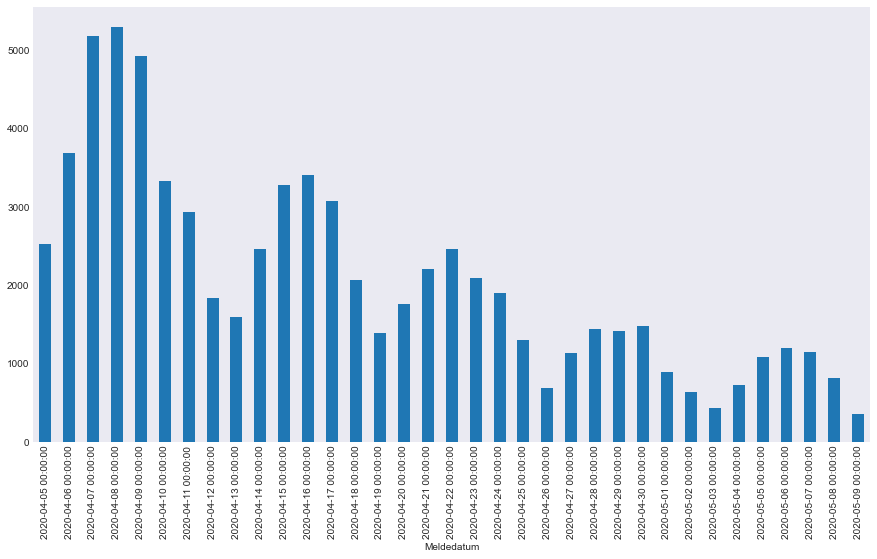

In [37]:
rki.NewCases['04-05-2020':].plot.bar()

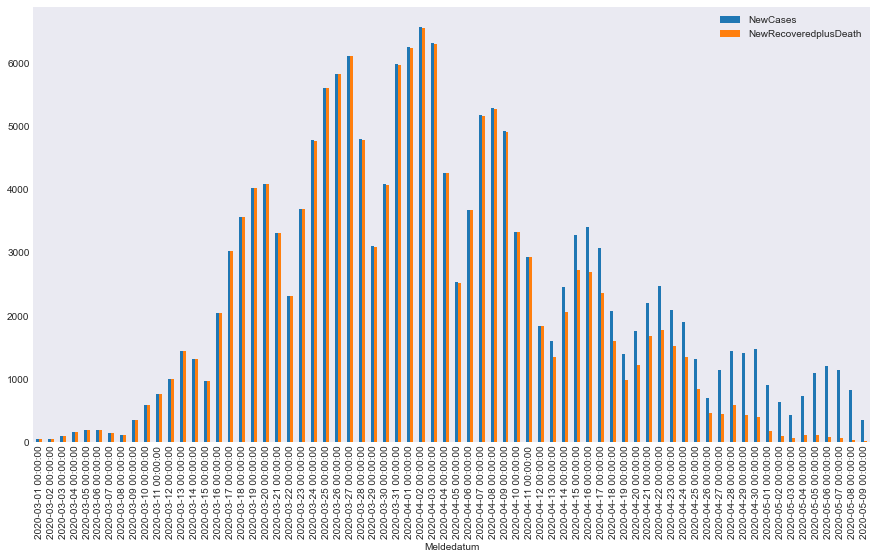

In [38]:
rki['NewRecoveredplusDeath'] = rki.NewRecoveredRKI + rki.NewDeath
rki['03-01-2020':][['NewCases', 'NewRecoveredplusDeath']].plot.bar()
rki.drop('NewRecoveredplusDeath', axis=1, inplace=True)

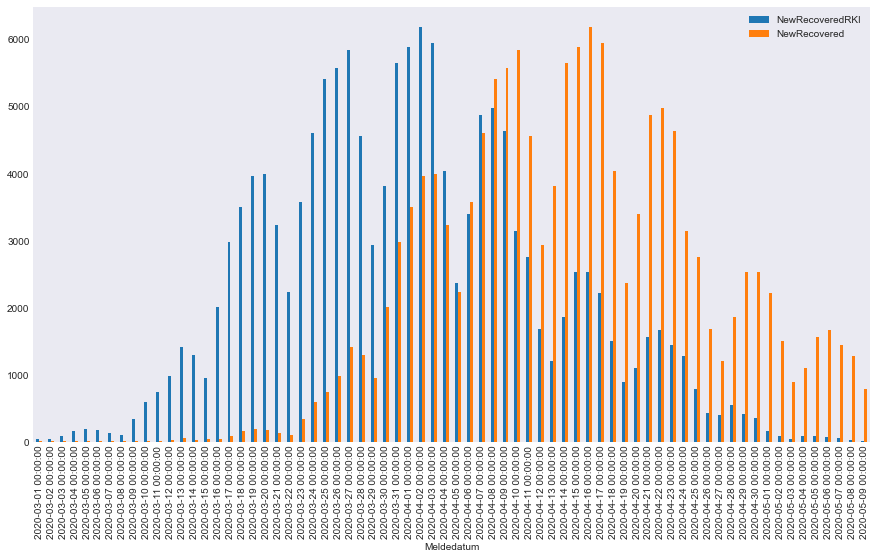

In [45]:
rki['03-01-2020':][['NewRecoveredRKI', 'NewRecovered']].plot.bar()

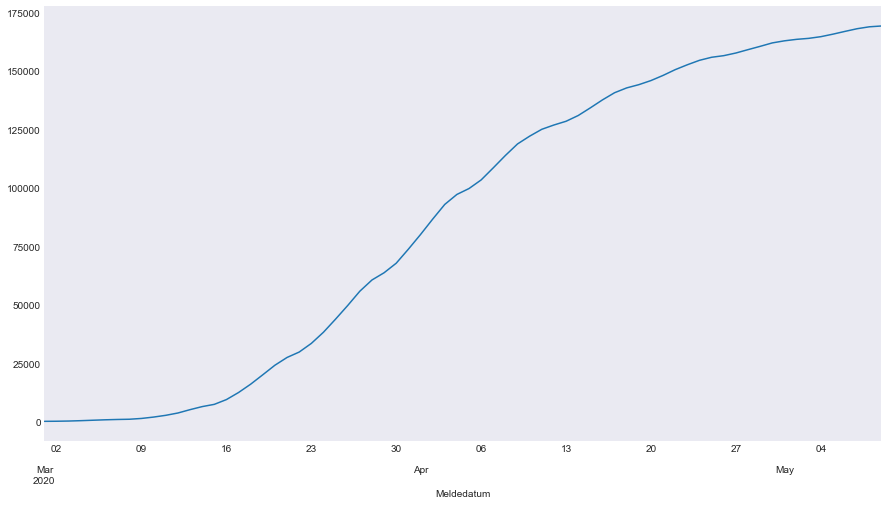

In [41]:
rki.Cases['03-01-2020':].plot()

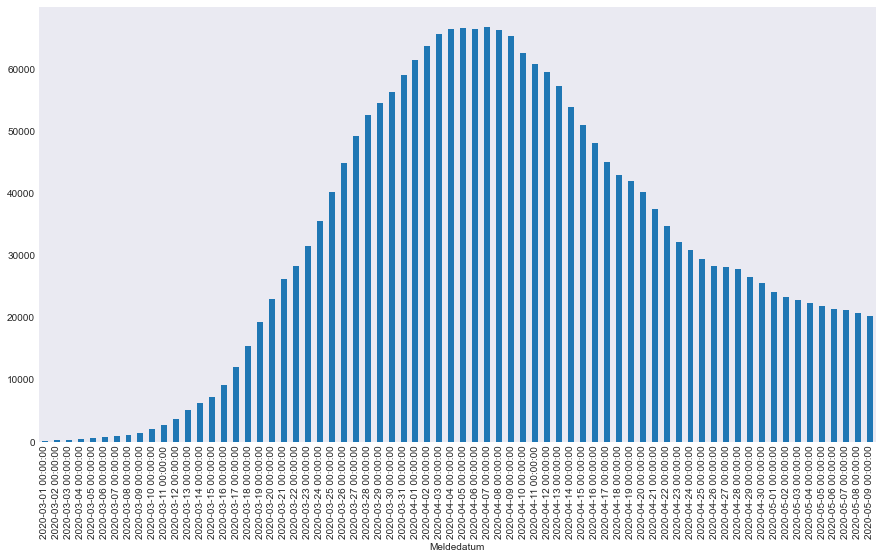

In [42]:
rki.ActiveCases['03-01-2020':].plot.bar()

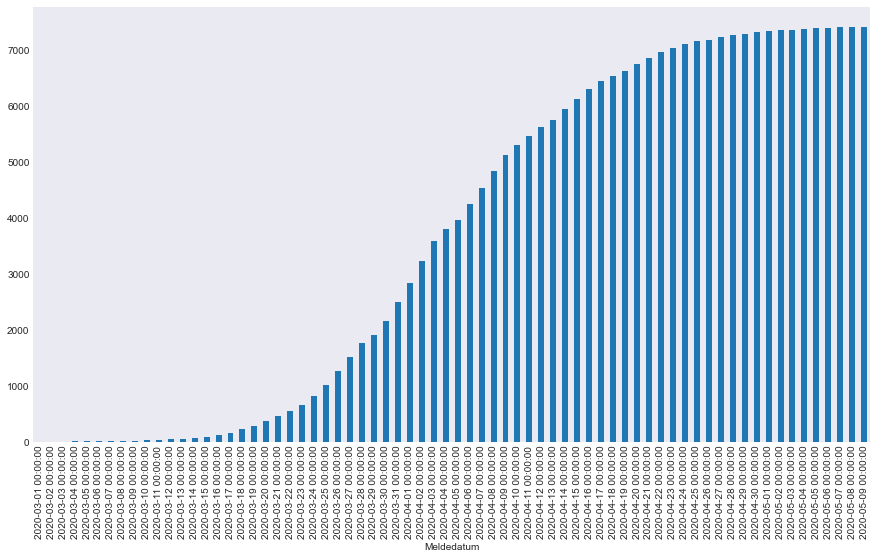

In [16]:
rki.Death['03-01-2020':].plot.bar()

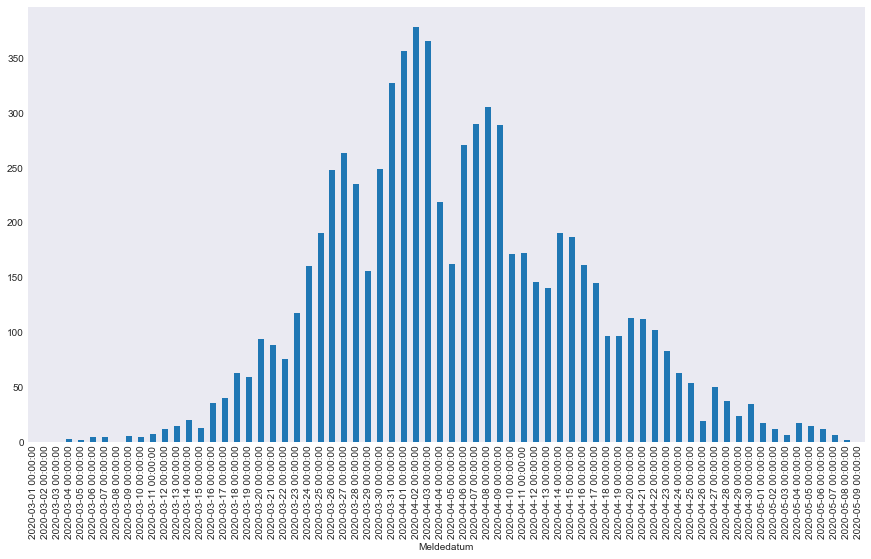

In [17]:
rki.NewDeath['03-01-2020':].plot.bar()

Text(0.5, 1.0, 'Growth Germany')

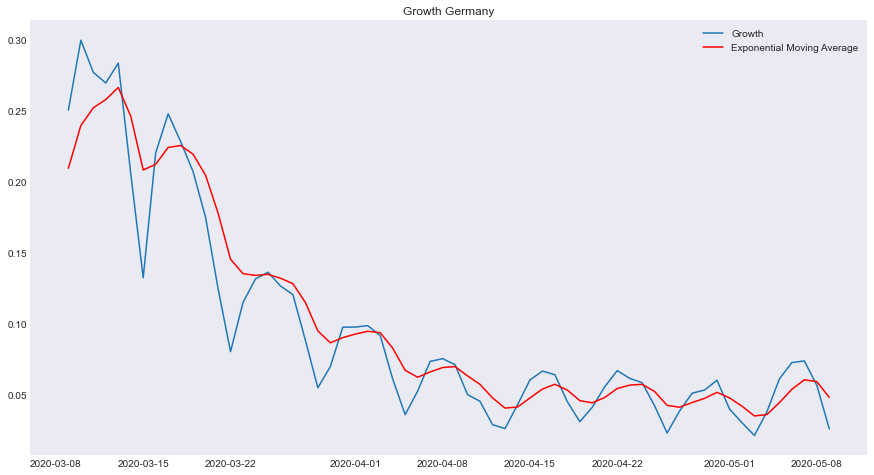

In [18]:
start_date = '03-09-2020'
x = rki[start_date:].index
plt.plot(x, rki.Growth[start_date:], label='Growth')
plt.plot(x, rki.Growth.ewm(span=5,adjust=False).mean()[start_date:], label='Exponential Moving Average', color='red')
plt.legend(loc='best')
plt.title('Growth Germany')

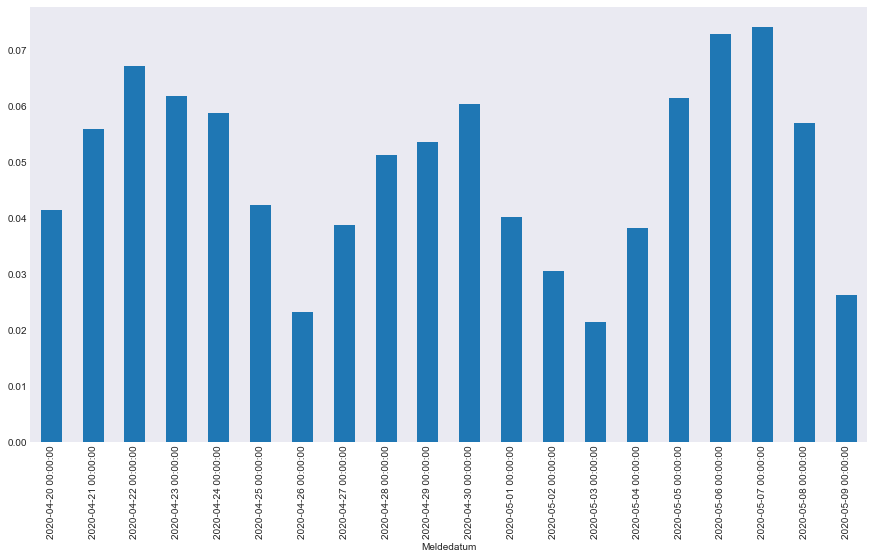

In [19]:
rki.Growth['04-20-2020':].plot.bar()

In [21]:
rki.tail(20)

,NewCases,NewDeath,NewRecoveredRKI,NewRecoveredJR,Cases,Death,RecoveredRKI,RecoveredJR,ActiveCases,Growth
Meldedatum,,,,,,,,,,
2020-04-20,1755,113.0,1100,3568.0,145884,6736.0,134921,96655.0,42493.0,0.041301
2020-04-21,2204,112.0,1562,5062.0,148088,6848.0,136483,101717.0,39523.0,0.055765
2020-04-22,2463,102.0,1661,5185.0,150551,6950.0,138144,106902.0,36699.0,0.067114
2020-04-23,2089,83.0,1438,4845.0,152640,7033.0,139582,111747.0,33860.0,0.061695
2020-04-24,1901,63.0,1278,3267.0,154541,7096.0,140860,115014.0,32431.0,0.058617
2020-04-25,1302,53.0,784,2880.0,155843,7149.0,141644,117894.0,30800.0,0.042273
2020-04-26,688,19.0,431,1818.0,156531,7168.0,142075,119712.0,29651.0,0.023203
2020-04-27,1130,50.0,392,1545.0,157661,7218.0,142467,121257.0,29186.0,0.038717
2020-04-28,1443,37.0,540,2416.0,159104,7255.0,143007,123673.0,28176.0,0.051214
